## Feature Evaluation and Modeling of AI4I 2020 Predictive Maintenance Dataset

<b>Problem Definition</b>:
Machine failures are caused by different factors such as the tool quality and how it's being used.
Understanding these factors is essential to predict future machine failures and help that organization
plan better for the disruption caused by machine failure. <br>
<br>
<b>Planned Goals</b>: Perform an analysis of the given data to determine how different features relate to the
target variable, i.e., machine failure. Build a machine learning model that can predict Machine failure.<br>
<br>
<b>Achieved Goals</b>: Reached the appropriate precision and recall for predicting machine failures. <br>
<br>
<b>To-Do(s)</b>: Considering using much more sophisticated models like Encoder-Decoder may increase the accuracy. <br>
<br>
<b>Contributors</b>: Kayhan B (Oct 2021)<br>
<br>
<b>Reviewers</b>: -<br>
<br>

<b>General Information</b>:<br>
- Please read the README for python environment handling. <br>
- More information about the defined problem is presented on (source):
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset
- Dataset for this problem is tabular and is stored inside the data folder.
<br>

<b> Data Attribute Information (from source)</b>:

The dataset consists of 10 000 data points stored as rows with 14 features in columns. <br>
<br>
- <b>UID</b>: unique identifier ranging from 1 to 10000 <br>
<br>
- <b>product ID</b>: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as 
product quality variants and a variant-specific serial number <br>
<br>
- <b>air temperature [K]</b>: generated using a random walk process later normalized to a standard deviation of 2 K around 
300 K <br>
<br>
- <b>process temperature [K]</b>: generated using a random walk process normalized to a standard deviation of 1 K, added 
to the air temperature plus 10 K. <br>
<br>
- <b>rotational speed [rpm]</b>: calculated from a power of 2860 W, overlaid with a normally distributed noise <br>
<br>
- <b>torque [Nm]</b>: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. <br>
<br>
- <b>tool wear [min]</b>: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. <br>
<br>

<b>'machine failure'</b> label that indicates, whether the machine has failed in this particular datapoint for any of the 
following failure modes are true.
<br>

The <b>machine failure</b> consists of five <b>independent</b> failure modes <br>
<br>
- <b>tool wear failure (TWF)</b>: the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240
mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned). <br>
<br>
- <b>heat dissipation failure (HDF)</b>: heat dissipation causes a process failure, if the difference between air- and process
temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points. <br>
<br>
- <b>power failure (PWF)</b>: the product of torque and rotational speed (in rad/s) equals the power required for the process.
If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset. <br>
<br>
- <b>overstrain failure (OSF)</b>: if the product of tool wear and torque exceeds 11,000 min Nm for the L product variant
(12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints. <br>
<br>
- <b>random failures (RNF)</b>: each process has a chance of 0.1 % to fail regardless of its process parameters. This is the case
for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset. <br>
<br>

If at least one of the above failure modes is true, the process fails and the <b>'machine failure'</b> label is set to 1.
Therefore, it is not transparent to the machine learning method, which of the failure modes has caused the process to fail.<br>
<br>

Let's set up the configs, modules and take a glance at the data.

In [1]:
# read configuration from config files
from config import settings

Notebook is started.
Reading the config file is finished.


In [2]:
# required libraries and helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import xgboost as xgb

In [3]:
%%time
# @formatter:on

# read data csv and store it in pandas dataframe
df = pd.read_csv(settings.notebook.feature_evaluation.data_source_path)
print(f"Dataframe length is: {len(df.index)}")
print(f"Number of columns is: {len(df.columns)}")
print(f"Columns inferred types are:")
print(df.dtypes)
df.head(5)

Dataframe length is: 10000
Number of columns is: 14
Columns inferred types are:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object
Wall time: 813 ms


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
%%time
# @formatter:on

# last five rows
df.tail(5)

Wall time: 0 ns


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0


In [5]:
%%time
# @formatter:on

# dataframe info and memory usage
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
%%time
# @formatter:on

# memory usage of each column in bytes
df.memory_usage(deep = True)

Wall time: 2.03 ms


Index                         128
UDI                         80000
Product ID                 630000
Type                       580000
Air temperature [K]         80000
Process temperature [K]     80000
Rotational speed [rpm]      80000
Torque [Nm]                 80000
Tool wear [min]             80000
Machine failure             80000
TWF                         80000
HDF                         80000
PWF                         80000
OSF                         80000
RNF                         80000
dtype: int64

In [7]:
%%time
# @formatter:on

# checking machine failures columns claimed attributes
col_names = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
for col_name in col_names:
    print(f"'{col_name}' column: % of ones in {((df[col_name] == 1).sum() / len(df.index)) * 100 :.2f}, "
          f"% of zeros in {((df[col_name] == 0).sum() / len(df.index)) * 100 :.2f}, "
          f"sum % = {(len(df[(df[col_name] == 0) | (df[col_name] == 1)].index) / len(df.index)) * 100 :.2f}")

'Machine failure' column: % of ones in 3.39, % of zeros in 96.61, sum % = 100.00
'TWF' column: % of ones in 0.46, % of zeros in 99.54, sum % = 100.00
'HDF' column: % of ones in 1.15, % of zeros in 98.85, sum % = 100.00
'PWF' column: % of ones in 0.95, % of zeros in 99.05, sum % = 100.00
'OSF' column: % of ones in 0.98, % of zeros in 99.02, sum % = 100.00
'RNF' column: % of ones in 0.19, % of zeros in 99.81, sum % = 100.00
Wall time: 13.9 ms


Target labels are correctly labeled as the sum of the ones and zeros equal to 100%. Data primarily represent the working state of machines.<br>
Let's check if the condition related to the <b>machine failure modes</b> stated as "if at least one of the failure modes is true,
the process fails and marked as machine failure" is true or not.

In [8]:
%%time
# @formatter:on

(df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0).equals(df['Machine failure'])

Wall time: 3 ms


False

Therefore, we have machine failures that are not precisely caused by main failure modes or failure modes do not cause the
machine failure. Let's see what we can find.

In [9]:
%%time
# @formatter:on

ser_failure_modes = (df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0)
df_check_failure_modes = pd.DataFrame()
for index, value in df['Machine failure'].items():
    if value != ser_failure_modes[index]:
        df_check_failure_modes = df_check_failure_modes.append(df.iloc[index])

print(f"Dataframe length is: {len(df_check_failure_modes.index)}")
df_check_failure_modes.head(10)

Dataframe length is: 27
Wall time: 113 ms


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1221,1222.0,M16081,M,297.0,308.3,1399.0,46.4,132.0,0.0,0.0,0.0,0.0,0.0,1.0
1302,1303.0,L48482,L,298.6,309.8,1505.0,45.7,144.0,0.0,0.0,0.0,0.0,0.0,1.0
1437,1438.0,H30851,H,298.8,309.9,1439.0,45.2,40.0,1.0,0.0,0.0,0.0,0.0,0.0
1748,1749.0,H31162,H,298.4,307.7,1626.0,31.1,166.0,0.0,0.0,0.0,0.0,0.0,1.0
2072,2073.0,L49252,L,299.6,309.5,1570.0,35.5,189.0,0.0,0.0,0.0,0.0,0.0,1.0
2559,2560.0,L49739,L,299.3,309.0,1447.0,50.4,140.0,0.0,0.0,0.0,0.0,0.0,1.0
2749,2750.0,M17609,M,299.7,309.2,1685.0,28.9,179.0,1.0,0.0,0.0,0.0,0.0,0.0
3065,3066.0,M17925,M,300.1,309.2,1687.0,27.7,95.0,0.0,0.0,0.0,0.0,0.0,1.0
3452,3453.0,H32866,H,301.6,310.5,1602.0,32.3,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4044,4045.0,M18904,M,301.9,310.9,1419.0,47.7,20.0,1.0,0.0,0.0,0.0,0.0,0.0


Twenty-seven cases with this problem. It seems some entries with RNF=1 are not considered as Machine Failure and
some Machine failures don't have a proper reason.
Let's check if that's true for RNF=1.

In [10]:
%%time
# @formatter:on

print(len(df_check_failure_modes[(df_check_failure_modes['RNF'] == 0) & (df_check_failure_modes['Machine failure'] == 1)].index))
print(len(df_check_failure_modes[(df_check_failure_modes['RNF'] == 0) & (df_check_failure_modes['Machine failure'] == 1)
                                 | (df_check_failure_modes['TWF'] == 1) | (df_check_failure_modes['PWF'] == 1)
                                 | (df_check_failure_modes['HDF'] == 1) | (df_check_failure_modes['OSF'] == 1)].index))
print(len(df_check_failure_modes[(df_check_failure_modes['RNF'] == 1) & (df_check_failure_modes['Machine failure'] == 1)].index))
print((df['RNF'] == 1).sum())
print(len(df[(df['RNF'] == 1) & (df['Machine failure'] == 1)].index))

9
9
0
19
1
Wall time: 5.56 ms


Considering a total of 27 cases that are discovered, nine instances of 'Machine failure' are equal to one without any failure mode reason.
(not even RNF) (inferred from the first three print statements), so we end up with 18 (=27-9) cases that RNF=1, and 'Machine failure'
is not equal to 1. but we have 19 entries (inferred from the fourth print statement) that satisfy the mentioned condition;
where is the last one? <br>
There's only one case that RNF=1 and Machine failure=1; let's see how it looks like (inferred from fifth print statement).

In [11]:
%%time
# @formatter:on

df[(df['RNF'] == 1) & (df['Machine failure'] == 1)].head()

Wall time: 995 µs


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
3611,3612,L50791,L,301.7,310.9,1405,46.4,207,1,1,0,0,0,1


Therefore, the reason is for this entry to be 'Machine failure' is related to the TWF, not RNF. From now on, we decided to correct
the main dataframe and include RNF in the machine failure column to have the unified 'Machine failure' column.
With that, we can forget about the modes of machine failure and satisfy the mentioned statement in the source "It is therefore not
transparent to the machine learning method, which of the failure modes has caused the process to fail."

In [12]:
%%time
# @formatter:on

df['Machine failure'] = (df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0)
(df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0).equals(df['Machine failure'])

Wall time: 7.08 ms


True

Let's check the type column to see if it matches with the data from Product ID.

In [13]:
%%time
# @formatter:on

ser_type_from_product_id = df['Product ID'].str.get(0)
ser_type_from_product_id.equals(df['Type'])

Wall time: 4.55 ms


True

It's matched. Let's separate the product variant from (numeric part of product id) as a separate column.

In [14]:
%%time
# @formatter:on

df['Product Var'] = df['Product ID'].str[1:].astype(int)
df.head()

Wall time: 4.01 ms


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Product Var
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,14860
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,47181
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,47182
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,47183
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,47184


Let's check the unique values of 'Product Var' and 'Type' that existed in our data.

In [15]:
%%time
# @formatter:on

print(len(df['Product Var'].unique()))
print(len(df['Type'].unique()))

10000
3
Wall time: 1.95 ms


Product variant dimension is the same as the dimension of our data, so each row describes a new variant. Therefore, for modeling,
useful columns are Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min],
Machine failure which the last column is the target column, and the rest are features.

Let's check if we have NaN in dataframe

In [16]:
%%time
# @formatter:on

print(f"Total number of NaN s:{df.isnull().sum().sum()}")


def print_null(df: pd.DataFrame):
    """
    print_null(dataframe)
    ...
    From a dataframe, prints:
    column name | number of null values
    """
    for col, val in zip(df.columns, df.isnull().sum()):
        print("Column: {0:15} | Null count: {1}".format(col, val))


print_null(df)

Total number of NaN s:0
Column: UDI             | Null count: 0
Column: Product ID      | Null count: 0
Column: Type            | Null count: 0
Column: Air temperature [K] | Null count: 0
Column: Process temperature [K] | Null count: 0
Column: Rotational speed [rpm] | Null count: 0
Column: Torque [Nm]     | Null count: 0
Column: Tool wear [min] | Null count: 0
Column: Machine failure | Null count: 0
Column: TWF             | Null count: 0
Column: HDF             | Null count: 0
Column: PWF             | Null count: 0
Column: OSF             | Null count: 0
Column: RNF             | Null count: 0
Column: Product Var     | Null count: 0
Wall time: 5.97 ms


We can calculate the Pearson Correlation Coefficient (r-value) between a variable and the objective. This measures the strength of a
linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1 (perfectly positively linear).
The r-value is not the best measure of the "usefulness" of a new variable. Still, it can give a first approximation of whether a
variable will be helpful to a machine learning model. <br>
We can also visually inspect a relationship with the target using the Kernel Density Estimate (KDE) plot. The kernel density estimate
shows the distribution of a single variable compares to the target feature. <br>
Data represents the reading of the environment and whether the machine had a failure or not, so it's not time-based, and we
need to consider the importance of each feature with the combination to the others in machine failure probability.
<br>

In [17]:
%%time
# @formatter:on

def plot_kde(var_col_name: str,
             target_col_name: str,
             df_plot: pd.DataFrame):
    if settings.notebook.feature_evaluation.plot_kde_func.activated:
        # Calculate the correlation coefficient between the variable and the target, pearson is default
        corr = df_plot[target_col_name].corr(df_plot[var_col_name])

        # Calculate median and mean
        median_working = df_plot.loc[df_plot[target_col_name] == 0, var_col_name].median()
        median_failed = df_plot.loc[df_plot[target_col_name] == 1, var_col_name].median()
        mean_working = df_plot.loc[df_plot[target_col_name] == 0, var_col_name].mean()
        mean_failed = df_plot.loc[df_plot[target_col_name] == 1, var_col_name].mean()

        plt.figure(figsize = (12, 6))

        # Plot the distribution
        sns.kdeplot(df_plot.loc[df_plot[target_col_name] == 0, var_col_name],
                    label = 'Machine failure == 0',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_func.machine_failure_0.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_func.machine_failure_0.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_func.machine_failure_0.line_color)
        sns.kdeplot(df_plot.loc[df_plot[target_col_name] == 1, var_col_name],
                    label = 'Machine failure == 1',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_func.machine_failure_1.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_func.machine_failure_1.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_func.machine_failure_1.line_color)

        # label the plot
        plt.xlabel(var_col_name)
        plt.ylabel('Density')
        plt.title(f'{var_col_name} Distribution')
        plt.legend()

        # print out the correlation
        print(f'The correlation between {var_col_name} and the {target_col_name} is {corr:0.4f}')

        # Print out average values
        print(f'{var_col_name}, Median: {median_working:0.4f}, mean: {mean_working:0.4f} for the working machine.')
        print(f'{var_col_name}, Median: {median_failed:0.4f}, mean: {mean_failed:0.4f} for the failed machine.')

Wall time: 0 ns


The correlation between Air temperature [K] and the Machine failure is 0.0845
Air temperature [K], Median: 300.0000, mean: 299.9729 for the working machine.
Air temperature [K], Median: 301.6000, mean: 300.8945 for the failed machine.
The correlation between Process temperature [K] and the Machine failure is 0.0398
Process temperature [K], Median: 310.0000, mean: 309.9943 for the working machine.
Process temperature [K], Median: 310.5000, mean: 310.3167 for the failed machine.
The correlation between Rotational speed [rpm] and the Machine failure is -0.0455
Rotational speed [rpm], Median: 1507.0000, mean: 1540.3244 for the working machine.
Rotational speed [rpm], Median: 1365.0000, mean: 1495.8333 for the failed machine.
The correlation between Torque [Nm] and the Machine failure is 0.1916
Torque [Nm], Median: 39.9000, mean: 39.6243 for the working machine.
Torque [Nm], Median: 53.6000, mean: 50.0437 for the failed machine.
The correlation between Tool wear [min] and the Machine failur

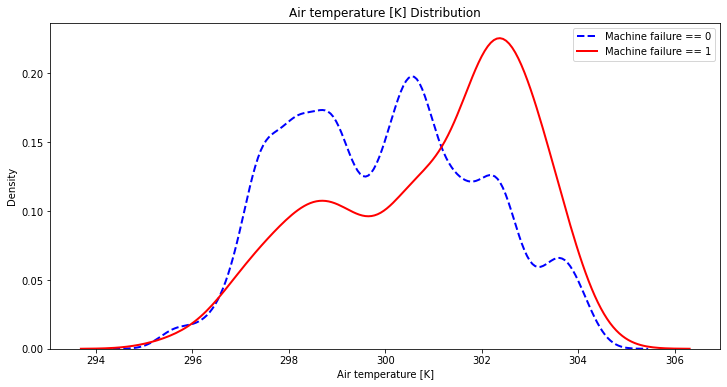

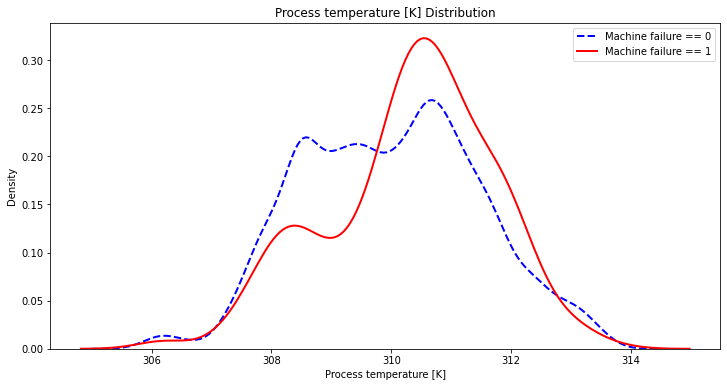

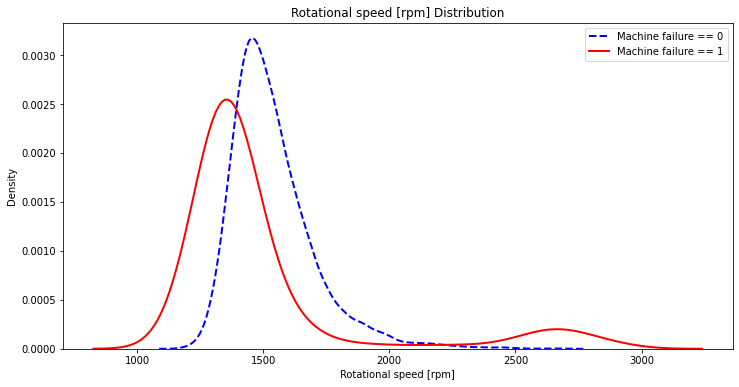

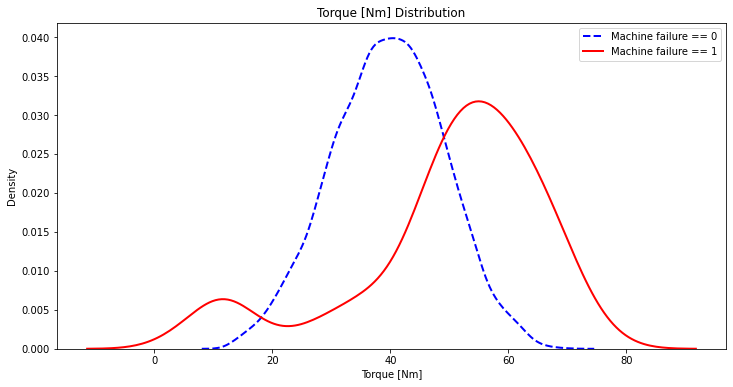

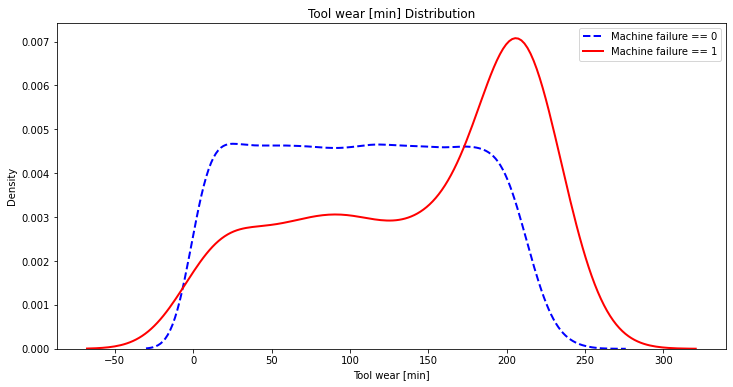

In [18]:
%%time
# @formatter:on

plot_kde(var_col_name = 'Air temperature [K]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Process temperature [K]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Rotational speed [rpm]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Torque [Nm]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Tool wear [min]',
         target_col_name = 'Machine failure',
         df_plot = df)

For Air temperature [K] feature, it seems higher temperature is causing a higher chance of machine failure. Instances with machine failure
have slightly higher mean and median Air temperature [K]. Process temperature [K] KDE plot does not provide a conclusion, but the Pearson correlation
is marginally less than Air temperature [K]. As the KDE plot demonstrates, slower Rotational speed [rpm] is causing more machine failures,
which makes sense based on the writer's experience. Higher Torque [Nm] clearly caused more machine failure, which is repeated for Tool wear [min]
as well. The highest correlation was 0.1916 (positive) for Torque [Nm], but there's no solid negative correlation.
Let's check the effect of Type in machine failures.

In [19]:
%%time
# @formatter:on

def plot_kde_multiple(var_col_name: str,
                      target_col_name: str,
                      df_plot: pd.DataFrame):
    if settings.notebook.feature_evaluation.plot_kde_multiple_func.activated:
        plt.figure(figsize = (12, 6))

        # Plot the distribution, Gaussian kernel as default
        sns.kdeplot(df_plot[(df_plot[target_col_name] == 0) & (df_plot['Type'] == 'L')][var_col_name],
                    label = 'Machine failure == 0, L',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.l.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.l.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.l.line_color)
        sns.kdeplot(df_plot[(df_plot[target_col_name] == 0) & (df_plot['Type'] == 'M')][var_col_name],
                    label = 'Machine failure == 0, M',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.m.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.m.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.m.line_color)
        sns.kdeplot(df_plot[(df_plot[target_col_name] == 0) & (df_plot['Type'] == 'H')][var_col_name],
                    label = 'Machine failure == 0, H',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.h.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.h.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_0.h.line_color)
        sns.kdeplot(df_plot[(df_plot[target_col_name] == 1) & (df_plot['Type'] == 'L')][var_col_name],
                    label = 'Machine failure == 1, L',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.l.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.l.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.l.line_color)
        sns.kdeplot(df_plot[(df_plot[target_col_name] == 1) & (df_plot['Type'] == 'M')][var_col_name],
                    label = 'Machine failure == 1, M',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.m.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.m.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.m.line_color)
        sns.kdeplot(df_plot[(df_plot[target_col_name] == 1) & (df_plot['Type'] == 'H')][var_col_name],
                    label = 'Machine failure == 1, H',
                    linestyle = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.h.line_style,
                    linewidth = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.h.line_width,
                    color = settings.notebook.feature_evaluation.plot_kde_multiple_func.machine_failure_1.h.line_color)

        # label the plot
        plt.xlabel(var_col_name)
        plt.ylabel('Density')
        plt.title(f'{var_col_name} Distribution')
        plt.legend()


Wall time: 0 ns


Wall time: 1min 18s


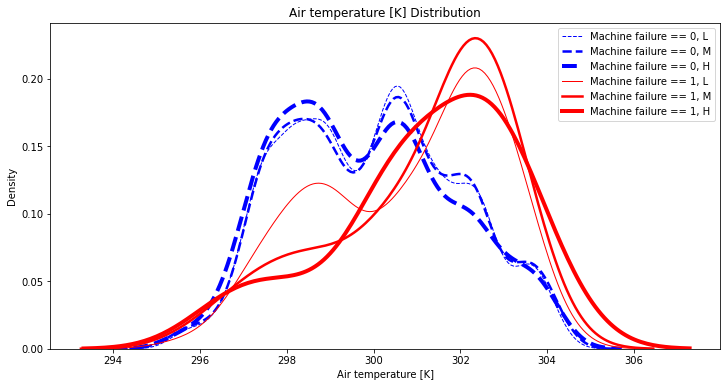

In [20]:
%%time
# @formatter:on

plot_kde_multiple(var_col_name = 'Air temperature [K]',
                  target_col_name = 'Machine failure',
                  df_plot = df)

Type change from L to H does not provide a solid conclusion about the machine failure rate considering Air temperature [K].

Wall time: 2min 1s


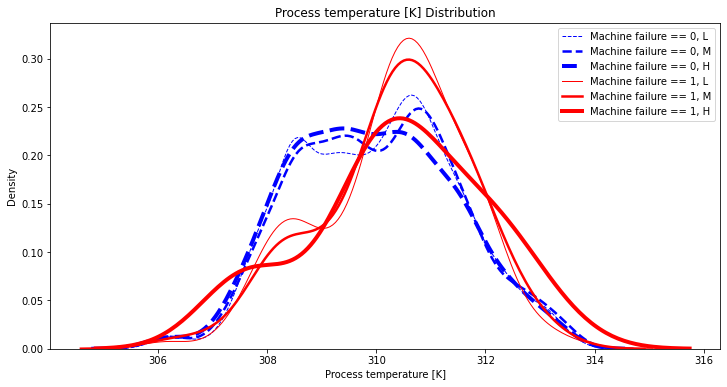

In [21]:
%%time
# @formatter:on

plot_kde_multiple(var_col_name = 'Process temperature [K]',
                  target_col_name = 'Machine failure',
                  df_plot = df)


Type change from L to H can show its effect on machine failure rate when the quality is higher the density is smaller at the peak.

Wall time: 2min 24s


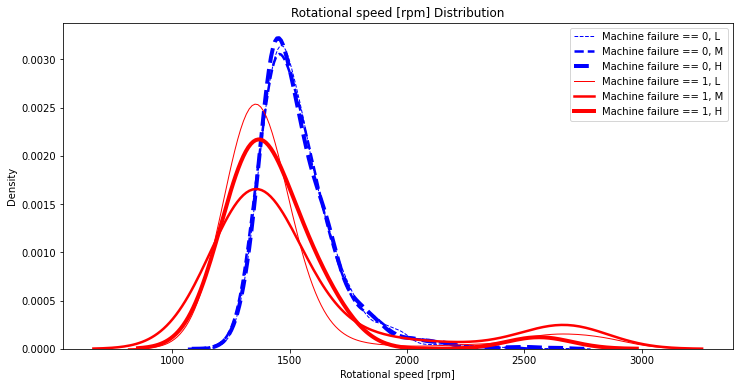

In [22]:
%%time
# @formatter:on

plot_kde_multiple(var_col_name = 'Rotational speed [rpm]',
                  target_col_name = 'Machine failure',
                  df_plot = df)



Type change from L to H does not provide a solid conclusion about the machine failure rate considering Rotational speed [rpm].

Wall time: 3min 13s


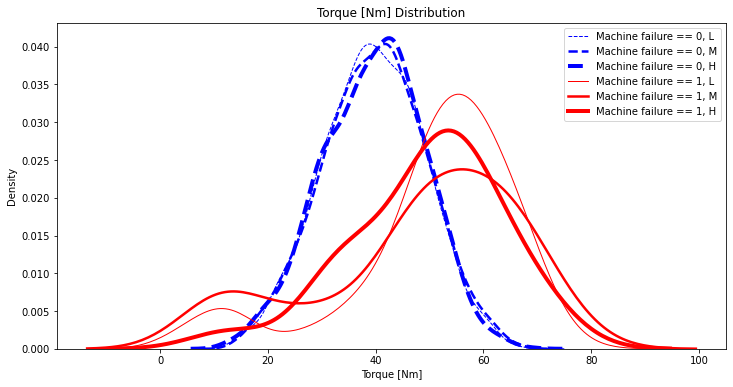

In [23]:
%%time
# @formatter:on

plot_kde_multiple(var_col_name = 'Torque [Nm]',
                  target_col_name = 'Machine failure',
                  df_plot = df)



Type change from L to H does not provide a solid conclusion about the machine failure rate considering Torque [Nm].

Wall time: 3min 37s


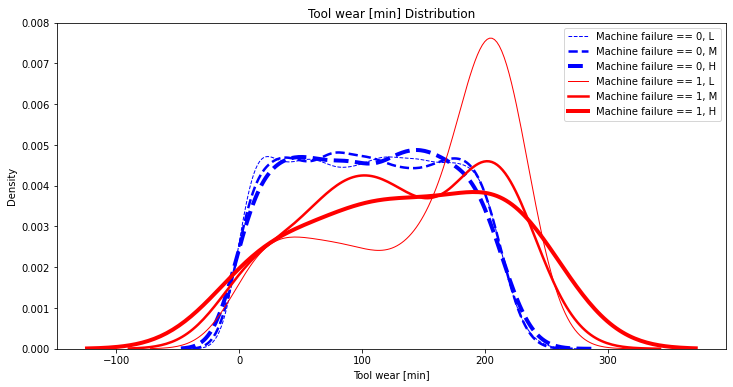

In [24]:
%%time
# @formatter:on

plot_kde_multiple(var_col_name = 'Tool wear [min]',
                  target_col_name = 'Machine failure',
                  df_plot = df)


Type change from L to H shows that machine failure rate decreases considering Tool wear [min]. Let's create more features
using four operands +, -, x, \ between every two features. We expect to add 5x4x4/2 = 40 more features.
For having a baseline, we will implement the logistic regression as the naive baseline.

In [25]:
%%time
# @formatter:on

col_names = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
col_len = len(col_names)
for inx, col_name in enumerate(col_names):
    for i in range(inx + 1, col_len):
        df[f"{col_names[inx]}+{col_names[i]}"] = df[col_names[inx]] + df[col_names[i]]
        df[f"{col_names[inx]}-{col_names[i]}"] = df[col_names[inx]] - df[col_names[i]]
        df[f"{col_names[inx]}*{col_names[i]}"] = df[col_names[inx]] * df[col_names[i]]
        df[f"{col_names[inx]}/{col_names[i]}"] = df[col_names[inx]] / (df[col_names[i]] + 1)
df = df.replace([np.inf, -np.inf], np.nan)
print(df.dtypes)
print_null(df)
df.head()

UDI                                                 int64
Product ID                                         object
Type                                               object
Air temperature [K]                               float64
Process temperature [K]                           float64
Rotational speed [rpm]                              int64
Torque [Nm]                                       float64
Tool wear [min]                                     int64
Machine failure                                     int64
TWF                                                 int64
HDF                                                 int64
PWF                                                 int64
OSF                                                 int64
RNF                                                 int64
Product Var                                         int32
Air temperature [K]+Process temperature [K]       float64
Air temperature [K]-Process temperature [K]       float64
Air temperatur

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,...,Rotational speed [rpm]*Torque [Nm],Rotational speed [rpm]/Torque [Nm],Rotational speed [rpm]+Tool wear [min],Rotational speed [rpm]-Tool wear [min],Rotational speed [rpm]*Tool wear [min],Rotational speed [rpm]/Tool wear [min],Torque [Nm]+Tool wear [min],Torque [Nm]-Tool wear [min],Torque [Nm]*Tool wear [min],Torque [Nm]/Tool wear [min]
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,66382.8,35.410959,1551,1551,0,1551.000000,42.8,42.8,0.0,42.800000
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,65190.4,29.767442,1411,1405,4224,352.000000,49.3,43.3,138.9,11.575000
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,...,74001.2,29.722222,1503,1493,7490,249.666667,54.4,44.4,247.0,8.233333
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,...,56603.5,35.382716,1440,1426,10031,179.125000,46.5,32.5,276.5,4.937500
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,...,56320.0,34.341463,1417,1399,12672,140.800000,49.0,31.0,360.0,4.000000


In the next step, we will create a pipe for categorical and numerical data, and we
will use a one-hot-encoder to change the values in the Type column.

In [26]:
%%time
# @formatter:on

target = df['Machine failure']
df = df.drop(labels = ["TWF", "HDF", "PWF", "OSF", "RNF", 'UDI', 'Machine failure', 'Product ID'], axis = 1)
categorical_preprocessor = OneHotEncoder(handle_unknown = "ignore")
numerical_preprocessor = StandardScaler()

numerical_columns_selector = selector(dtype_exclude = object)
categorical_columns_selector = selector(dtype_include = object)

numerical_columns = numerical_columns_selector(df)
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, ['Type']),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])
model = make_pipeline(preprocessor, LogisticRegression(max_iter = settings.notebook.feature_evaluation.logistic_regression.max_iter))
set_config(display = 'diagram')
model

Wall time: 9.64 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]',
                                                   'Product Var',
                                                   'Air temperature '
                                                   '[K]+Process temperature '
                                                   '[K]',
                                                   'Air temperature '
                                                   '[K]-...
                                                   'Process temperature '
                                                   '[K]-Rotational speed [rpm]',
                                                   'Process temperature '
                                                   '[K]*Rotational speed [rpm]',
                                                   'Process temperature '
                                                   '[K]/Rotational speed [rpm]',
                                                   'Process temperature '
                                                   '[K]+Torque [Nm]',
                                                   'Process temperature '
                                                   '[K]-Torque [Nm]',
                                                   'Process temperature '
                                                   '[K]*Torque [Nm]',
                                                   'Process temperature '
                                                   '[K]/Torque [Nm]', ...])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In this step, train and test data will be separated. Configs can be changed using the default_settings.yml
file under the config folder. Because the number of machine failures is much smaller, we may face an imbalanced
dataset problem which means that model will predict the dominant class much better than the others.

In [27]:
%%time
# @formatter:on

data_train, data_test, target_train, target_test = train_test_split(df,
                                                                    target,
                                                                    test_size = settings.notebook.feature_evaluation.logistic_regression.test_size,
                                                                    stratify = target,
                                                                    random_state = 42)
_ = model.fit(data_train, target_train)
print(target_test.head())
y_pred = model.predict(data_test)
y_pred[:5]

1091    0
327     1
2179    0
5750    0
3946    0
Name: Machine failure, dtype: int64
Wall time: 9.34 s


array([0, 0, 0, 0, 0], dtype=int64)

In the first five predictions, we found one mistake; let's dig deeper.

In [28]:
%%time
# @formatter:on

print(f"Model Score: {model.score(data_test, target_test)}")
cv_results = cross_validate(model, df, target, cv = 5)
print(f"CV results: {cv_results}")
scores = cv_results["test_score"]
print(f"The mean cross-validation accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")

Model Score: 0.9706666666666667
CV results: {'fit_time': array([0.34601831, 0.31704569, 0.32852554, 0.31221509, 0.30325532]), 'score_time': array([0.0050323 , 0.00600052, 0.00502443, 0.00503159, 0.0068326 ]), 'test_score': array([0.972 , 0.9655, 0.96  , 0.973 , 0.9685])}
The mean cross-validation accuracy is: 0.968 +/- 0.005
Wall time: 1.65 s


Machine failure [0 1], precision: [0.97240915 0.78571429]
Machine failure [0 1], recall: [0.99792818 0.21153846]
Machine failure [0 1], f_score: [0.98500341 0.33333333]
Machine failure [0 1], support: [1448   52]


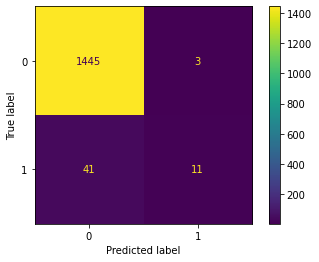

Wall time: 144 ms


In [29]:
%%time
# @formatter:on

precision, recall, f_score, support = score(target_test, y_pred)
print(f'Machine failure {model.classes_}, precision: {precision}')
print(f'Machine failure {model.classes_}, recall: {recall}')
print(f'Machine failure {model.classes_}, f_score: {f_score}')
print(f'Machine failure {model.classes_}, support: {support}')
cm = confusion_matrix(y_true = target_test,
                      y_pred = y_pred,
                      labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = model.classes_)
disp.plot()
plt.show()

Model results are not satisfactory; we should see what changes in variables can help to improve the levels of
low precision and recall.
Let's see, using only the initial features, what would be changed.

Model Score: 0.9673333333333334
CV results: {'fit_time': array([0.06900096, 0.05899882, 0.0329957 , 0.04610729, 0.04230595]), 'score_time': array([0.00800085, 0.0049994 , 0.00399995, 0.00403047, 0.00400138]), 'test_score': array([0.968 , 0.968 , 0.9565, 0.971 , 0.967 ])}
The mean cross-validation accuracy is: 0.966 +/- 0.005
Machine failure [0 1], precision: [0.96851976 0.71428571]
Machine failure [0 1], recall: [0.99861878 0.09615385]
Machine failure [0 1], f_score: [0.983339   0.16949153]
Machine failure [0 1], support: [1448   52]


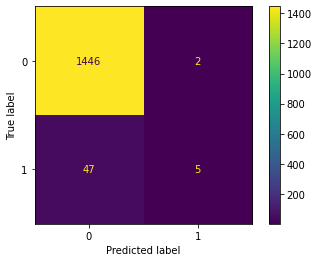

Wall time: 20.8 s


In [30]:
%%time
# @formatter:on

col_names = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type']
numerical_columns = numerical_columns_selector(df[col_names])
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, ['Type']),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])
model = make_pipeline(preprocessor, LogisticRegression(max_iter = settings.notebook.feature_evaluation.logistic_regression.max_iter))
data_train, data_test, target_train, target_test = train_test_split(df[col_names],
                                                                    target,
                                                                    test_size = settings.notebook.feature_evaluation.logistic_regression.test_size,
                                                                    stratify = target,
                                                                    random_state = 42)
_ = model.fit(data_train, target_train)
print(f"Model Score: {model.score(data_test, target_test)}")
cv_results = cross_validate(model, df[col_names], target, cv = 5)
print(f"CV results: {cv_results}")
scores = cv_results["test_score"]
print(f"The mean cross-validation accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")
y_pred = model.predict(data_test)
precision, recall, f_score, support = score(target_test, y_pred)
print(f'Machine failure {model.classes_}, precision: {precision}')
print(f'Machine failure {model.classes_}, recall: {recall}')
print(f'Machine failure {model.classes_}, f_score: {f_score}')
print(f'Machine failure {model.classes_}, support: {support}')
cm = confusion_matrix(y_true = target_test,
                      y_pred = y_pred,
                      labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = model.classes_)
disp.plot()
plt.show()

Decrease in precision and recall; this may cause by not using all features and having an imbalanced target.
Let's use SMOTE so target columns become more balanced; SMOTE will create synthetic data points for the minority class.
It creates new instances between the points of the minority class.

Model Score: 0.8013333333333333
CV results: {'fit_time': array([0.07626867, 0.11172605, 0.08005095, 0.06805778, 0.06830335]), 'score_time': array([0.00928164, 0.00401306, 0.00500751, 0.00401473, 0.00502515]), 'test_score': array([0.949 , 0.7075, 0.512 , 0.841 , 0.966 ])}
The mean cross-validation accuracy is: 0.795 +/- 0.169
Machine failure [0 1], precision: [0.99313894 0.13173653]
Machine failure [0 1], recall: [0.79972376 0.84615385]
Machine failure [0 1], f_score: [0.88599847 0.22797927]
Machine failure [0 1], support: [1448   52]


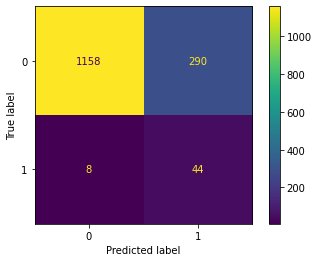

Wall time: 22.2 s


In [31]:
%%time
# @formatter:on

col_names = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type']
numerical_columns = numerical_columns_selector(df[col_names])
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, ['Type']),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])
sm = SMOTE(random_state = 42)
#data_train, target_train = sm.fit_resample(data_train, target_train)
model = make_pipeline(preprocessor, sm, LogisticRegression(max_iter = settings.notebook.feature_evaluation.logistic_regression.max_iter))
#model = make_pipeline(preprocessor, LogisticRegression(max_iter = settings.notebook.feature_evaluation.logistic_regression.max_iter))
data_train, data_test, target_train, target_test = train_test_split(df[col_names],
                                                                    target,
                                                                    test_size = settings.notebook.feature_evaluation.logistic_regression.test_size,
                                                                    stratify = target,
                                                                    random_state = 42)

_ = model.fit(data_train, target_train)
print(f"Model Score: {model.score(data_test, target_test)}")
cv_results = cross_validate(model, df[col_names], target, cv = 5)
print(f"CV results: {cv_results}")
scores = cv_results["test_score"]
print(f"The mean cross-validation accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")
y_pred = model.predict(data_test)
precision, recall, f_score, support = score(target_test, y_pred)
print(f'Machine failure {model.classes_}, precision: {precision}')
print(f'Machine failure {model.classes_}, recall: {recall}')
print(f'Machine failure {model.classes_}, f_score: {f_score}')
print(f'Machine failure {model.classes_}, support: {support}')
cm = confusion_matrix(y_true = target_test,
                      y_pred = y_pred,
                      labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = model.classes_)
disp.plot()
plt.show()

Much better results, what if we use all the features that we generated previously.

Model Score: 0.8513333333333334
CV results: {'fit_time': array([0.99501371, 1.33698106, 1.1518364 , 1.3000071 , 1.06494164]), 'score_time': array([0.00503087, 0.0059967 , 0.00619793, 0.00699759, 0.0061841 ]), 'test_score': array([0.9705, 0.7685, 0.601 , 0.836 , 0.974 ])}
The mean cross-validation accuracy is: 0.830 +/- 0.139
Machine failure [0 1], precision: [0.99756296 0.18215613]
Machine failure [0 1], recall: [0.8480663  0.94230769]
Machine failure [0 1], f_score: [0.91675999 0.30529595]
Machine failure [0 1], support: [1448   52]


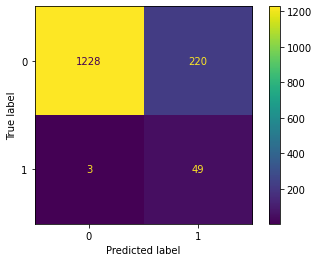

Wall time: 28.5 s


In [32]:
%%time
# @formatter:on

numerical_columns = numerical_columns_selector(df)
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, ['Type']),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])
sm = SMOTE(random_state = 42)
model = make_pipeline(preprocessor, sm, LogisticRegression(max_iter = settings.notebook.feature_evaluation.logistic_regression.max_iter))
data_train, data_test, target_train, target_test = train_test_split(df,
                                                                    target,
                                                                    test_size = settings.notebook.feature_evaluation.logistic_regression.test_size,
                                                                    stratify = target,
                                                                    random_state = 42)

_ = model.fit(data_train, target_train)
print(f"Model Score: {model.score(data_test, target_test)}")
cv_results = cross_validate(model, df, target, cv = 5)
print(f"CV results: {cv_results}")
scores = cv_results["test_score"]
print(f"The mean cross-validation accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")
y_pred = model.predict(data_test)
precision, recall, f_score, support = score(target_test, y_pred)
print(f'Machine failure {model.classes_}, precision: {precision}')
print(f'Machine failure {model.classes_}, recall: {recall}')
print(f'Machine failure {model.classes_}, f_score: {f_score}')
print(f'Machine failure {model.classes_}, support: {support}')
cm = confusion_matrix(y_true = target_test,
                      y_pred = y_pred,
                      labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = model.classes_)
disp.plot()
plt.show()

Improved compared to not using all features. How about using more complex models like XGBoost.

Model Score: 0.9866666666666667
CV results: {'fit_time': array([3.5995636 , 3.68599939, 3.31200337, 3.95900035, 3.30699778]), 'score_time': array([0.0150001 , 0.01300001, 0.01199651, 0.01600027, 0.01299858]), 'test_score': array([0.9895, 0.9075, 0.562 , 0.888 , 0.989 ])}
The mean cross-validation accuracy is: 0.867 +/- 0.158
Machine failure [0 1], precision: [0.99652295 0.75806452]
Machine failure [0 1], recall: [0.98964088 0.90384615]
Machine failure [0 1], f_score: [0.99306999 0.8245614 ]
Machine failure [0 1], support: [1448   52]


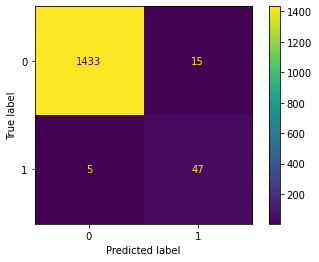

Wall time: 43.2 s


In [33]:
%%time
# @formatter:on

numerical_columns = numerical_columns_selector(df)
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, ['Type']),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])
sm = SMOTE(random_state = 42)
model = make_pipeline(preprocessor, sm, xgb.XGBClassifier(booster = 'gbtree',
                                                          max_depth = settings.notebook.feature_evaluation.xgboost.max_depth,
                                                          objective = 'binary:logistic',
                                                          verbosity = 0,
                                                          random_state = 42,
                                                          use_label_encoder = False))
data_train, data_test, target_train, target_test = train_test_split(df,
                                                                    target,
                                                                    test_size = settings.notebook.feature_evaluation.xgboost.test_size,
                                                                    stratify = target,
                                                                    random_state = 42)

_ = model.fit(data_train, target_train)
print(f"Model Score: {model.score(data_test, target_test)}")
cv_results = cross_validate(model, df, target, cv = 5)
print(f"CV results: {cv_results}")
scores = cv_results["test_score"]
print(f"The mean cross-validation accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")
y_pred = model.predict(data_test)
precision, recall, f_score, support = score(target_test, y_pred)
print(f'Machine failure {model.classes_}, precision: {precision}')
print(f'Machine failure {model.classes_}, recall: {recall}')
print(f'Machine failure {model.classes_}, f_score: {f_score}')
print(f'Machine failure {model.classes_}, support: {support}')
cm = confusion_matrix(y_true = target_test,
                      y_pred = y_pred,
                      labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = model.classes_)
disp.plot()
plt.show()


Much better than linear regression as we reduced the number of false prediction of machine failures.
Using more complex models like Encoder-Decoder can
help to increase these levels even higher.


